UMPM
extract pose with openpose
	elapsed 0.00037932395935058594


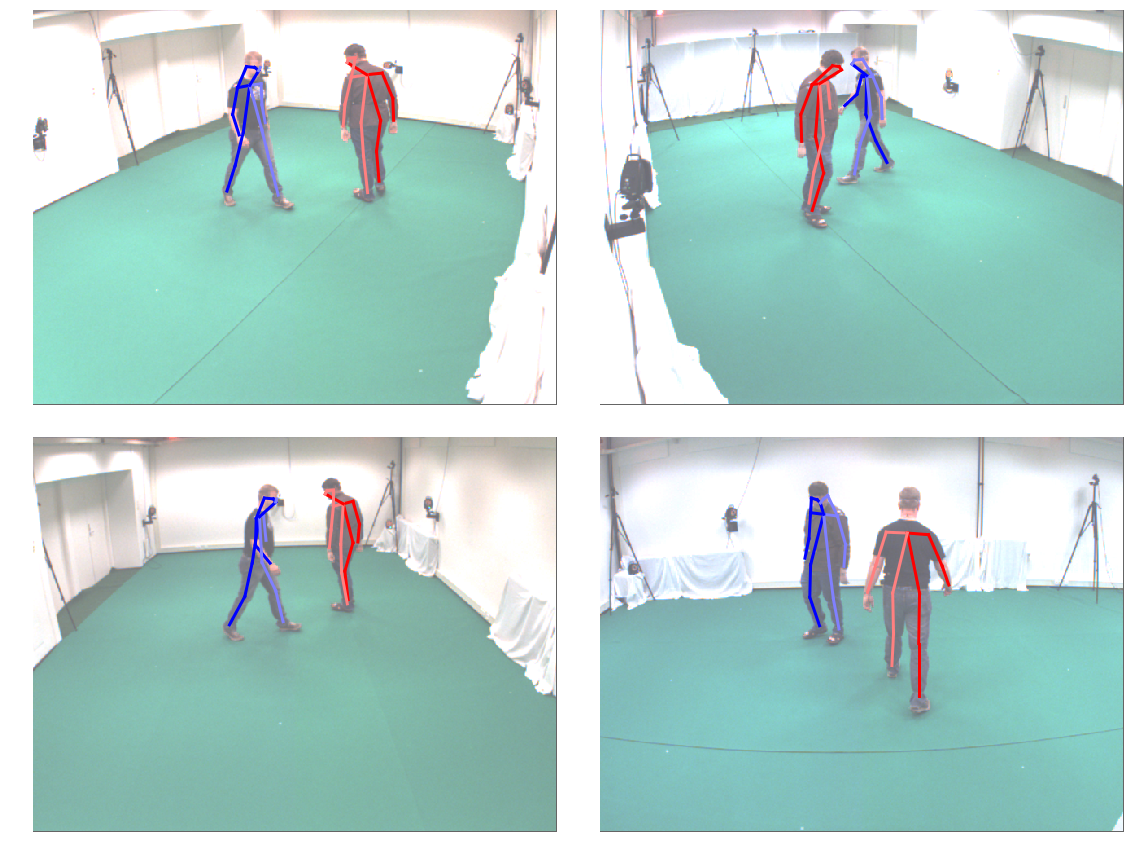

In [2]:
%matplotlib inline
# ---- settings ----

# import os
# os.environ["CUDA_VISIBLE_DEVICES"] = ""

import json
Settings = json.load(open('../settings.txt'))
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import sys
sys.path.insert(0, '../'); sys.path.insert(0, '../samples')
sys.path.insert(0, './')
import paf_loader
from os.path import join, isdir
import numpy as np
import cv2
from cselect import color as cs
from time import time
from mvpose import settings

from mvpose.data import umpm

params = settings.get_settings(ms_radius=30)
root = join(Settings['data_root'], 'pak')
user = Settings['UMPM']['username']
pwd = Settings['UMPM']['password']
tmp = Settings['tmp']

FRAME = 1430
#FRAME = 0
video = 'p2_free_1'

X, Y, Calib = umpm.get(root, video, user, pwd)

Im = np.array([X[0][FRAME], X[1][FRAME], X[2][FRAME], X[3][FRAME]])

# heatmaps, pafs = paf_loader.load_confidence_map_and_paf('umpm', Im, 
#                                                         FRAME, 
#                                                         dir=tmp)

# ====================================
# from poseestimation import model
# pe = model.PoseEstimator()
from openpose import OpenPose

pe = OpenPose()

print('extract pose with openpose')
_start = time()
positions = pe.predict(Im, 'umpm_' + video, FRAME)
_end = time()
print('\telapsed', _end - _start)
# ====================================

from mvpose.algorithm.candidate_selection import project_human_to_2d
from mvpose.plot.limbs import draw_mscoco_human, draw_mscoco_human2d

# Humans = detections

fig = plt.figure(figsize=(16,12))

colors = ['red', 'blue', 'green']

for idx, cam in enumerate(Calib):
    ax = fig.add_subplot(2,2,1+idx)
    ax.axis('off')
    im = Im[idx]
    h,w,_ = im.shape
    ax.imshow(im, alpha=0.6)
    
    for pid, person in enumerate(positions[idx]):
        draw_mscoco_human2d(ax, person[:, 0:2], 
                            color=colors[pid], linewidth=3)
    
plt.tight_layout()
plt.show()